In [ ]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
import random
import torch
import torchio as tio
from torchio.transforms import HistogramStandardization
import matplotlib.pyplot as plt
from dataset_tio import calculate_overlap, sim_data, MRBrainS18_data, HCP_data, mixed_data, MRBrainS18Image, HCPImage, SimImage, OASISImage
from transform import Normalize, RandomIntensity, Intensity, RandomGamma, RandomBiasField
from glob import glob
import torchvision
from models.generator_ESRGAN import GeneratorRRDB as generator_ESRGAN
from models.generator_RRDB import GeneratorRRDB as generator_RRDB
from models.generator_DeepUResnet import DeepUResnet as generator_DeepUResnet
from models.discriminator import Discriminator
from models.feature_extractor import FeatureExtractor

from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
import pytorch_lightning as pl

from torchvision.utils import save_image
from torchsummary import summary
import time
from utils import save_subject, save_subject_all, get_mean_and_std
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import normalized_root_mse as NRMSE
from skimage import exposure
from skimage import filters
from utils import square_mask, cuboid_mask

print(os.getcwd())

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
std = 0.3548

In [ ]:
img_real = HCPImage(number=129634, middle_slices=None, every_other=1, augment=False)
real_subject = [img_real.subject()]
real_set = tio.SubjectsDataset(
    real_subject, transform=Normalize(std=std))

real_set[0].plot()

In [ ]:
img_sim = SimImage(number=120010, middle_slices=None, every_other=1, data_resolution='1mm_07mm')
sim_subject = [img_sim.subject()]

sim_set = tio.SubjectsDataset(
    sim_subject, transform=Normalize(std=std))

sim_set[0].plot()

In [ ]:
def fft2_plot(slice):
    return torch.log10(torch.abs(torch.fft.fftshift(torch.fft.fft2(slice))))

def fft2_plot_diff(slice1, slice2):
    slice1_fft = torch.fft.fftshift(torch.fft.fft2(slice1))
    slice2_fft = torch.fft.fftshift(torch.fft.fft2(slice2))
    return torch.log10(torch.abs(slice1_fft-slice2_fft))

def fft2_plot_masked(slice, mask):
    slice_fft = torch.fft.fftshift(torch.fft.fft2(slice))
    return torch.log10(torch.abs(slice_fft))*mask

def freq_energy(slice, mask):
    slice_fft = torch.fft.fftshift(torch.fft.fft2(slice))
    masked_fft = slice_fft*mask
    energy = torch.sum(torch.abs(torch.square(masked_fft)))
    return energy

In [ ]:
source = 'sim'

if source =='hcp':
    LR = img_real.subject()['LR']
    HR = img_real.subject()['HR']
elif source =='sim':
    LR = img_sim.subject()['LR']
    HR = img_sim.subject()['HR']

LR_slice = LR.data[0,:,:,100]
HR_slice = HR.data[0,:,:,100]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.set_facecolor('white')
# for axis in axes:
#     for xs in axis:
#         xs.set_axis_off()
axes[0,0].set_title('LR', size=20)
axes[0,0].imshow(LR_slice, cmap='gray', vmin=0, vmax=1.2)
axes[1,0].imshow(fft2_plot(LR_slice), cmap='gray', vmin=-2.5, vmax=4.5)

axes[0,1].set_title('HR', size=20)
axes[0,1].imshow(HR_slice, cmap='gray', vmin=0, vmax=1.2)
axes[1,1].imshow(fft2_plot(HR_slice), cmap='gray', vmin=-2.5, vmax=4.5)

axes[0,2].set_title('Diff', size=20)
axes[0,2].imshow(HR_slice-LR_slice, cmap='gray', vmin=-.1, vmax=.1)
axes[1,2].imshow(fft2_plot(HR_slice)-fft2_plot(LR_slice), cmap='gray', vmin=-2.5, vmax=4.5)

In [ ]:
img_sim = SimImage(number=129634, middle_slices=None, every_other=1, data_resolution='1mm_07mm', augment=False)
img_real = HCPImage(number=129634, middle_slices=None, every_other=1, augment=False)
# img_real_aug = HCPImage(number=129634, middle_slices=None, every_other=1, augment=True)
img_oasis = OASISImage(number=1, middle_slices=None, every_other=1)
img_mrbrains18 = MRBrainS18Image(number=1, middle_slices=None, every_other=1)
slice = 100

LR_slice = img_real.subject()['LR'].data[0,:,:,slice]


In [ ]:
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

window = signal.tukey(51)
plt.plot(window)
plt.title("Tukey window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.ylim([0, 1.1])

plt.figure()
A = fft(window, 2048) / (len(window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the Tukey window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")

In [ ]:
LR_slice = img_real.subject()['LR'].data[0,:,:,slice].numpy()
HR_slice = img_real.subject()['HR'].data[0,:,:,slice].numpy()

window = signal.tukey(LR_slice.shape[0], alpha=0.5)
window2d = np.repeat(window[:,np.newaxis], LR_slice.shape[1], axis=1)
mask = (1-(np.rot90(window2d)*window2d))*30

fourier_lr = np.fft.fftshift(np.fft.fft2(LR_slice))
fourier_hr = np.fft.fftshift(np.fft.fft2(HR_slice))
added = fourier_lr+mask*fourier_lr
reverse = np.fft.ifft2(np.fft.ifftshift(added))

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
fig.set_facecolor('white')

axes[0,0].set_title('LR slice')
axes[0,0].imshow(LR_slice, cmap='gray', vmin=0, vmax=1.2)
axes[0,0].set_axis_off()
axes[1,0].set_title('LR Fourier (log scale)')
axes[1,0].imshow(np.log10(np.abs(fourier_lr)), cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,0].set_axis_off()

axes[0,1].set_title('HR slice')
axes[0,1].imshow(HR_slice, cmap='gray', vmin=0, vmax=1.2)
axes[0,1].set_axis_off()
axes[1,1].set_title('HR Fourier (log scale)')
axes[1,1].imshow(np.log10(np.abs(fourier_hr)), cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,1].set_axis_off()

axes[0,2].set_title('2D Tukey')
axes[0,2].imshow(mask, cmap='gray')
axes[1,2].set_title('Tukey Profile')
axes[1,2].plot(mask[160,:])
axes[1,2].set_box_aspect(1)

axes[0,3].set_title('Added freqs LR (increased contrast)')
axes[0,3].imshow(np.abs(np.fft.ifft2(np.fft.ifftshift(mask*fourier_lr))), cmap='gray', vmin=0, vmax=.2)
axes[0,3].set_axis_off()
axes[1,3].set_title('Added freqs fourier LR (log scale)')
axes[1,3].imshow(np.log10(np.abs(mask*fourier_lr+1e-10)), cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,3].set_axis_off()

axes[0,4].set_title('LR slice + added freqs')
axes[0,4].imshow(np.abs(reverse), cmap='gray', vmin=0, vmax=1.2)
axes[0,4].set_axis_off()
axes[1,4].set_title('LR Fourier + added freqs (log scale)')
axes[1,4].imshow(np.log10(np.abs(added)), cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,4].set_axis_off()

In [ ]:
fig = plt.figure(figsize=[10,7])
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.set_title('PSD')
ax.psd(LR_slice.flatten(), label='LR')
ax.psd(np.abs(reverse).flatten(), label='LR Tukey')
ax.psd(HR_slice.flatten(), label='HR')
ax.legend()

In [148]:
slice = 100

HR_slice = img_real.subject()['HR'].data[0,:,:,slice].numpy()

padding = 60
alpha = 0.5
padding_value = 0.4

# make LR filter
t25x = signal.tukey(HR_slice.shape[0]-2*padding,alpha)   # as per image size and desired window size
t25y = signal.tukey(HR_slice.shape[0]-2*padding,alpha)
[maskt25x,maskt25y] = np.meshgrid(t25x,t25y)
Bt25xyz = (maskt25x*maskt25y)*(1-padding_value)+padding_value

# keep high freq
added = signal.tukey(HR_slice.shape[0], .2)
[added_x,added_y] = np.meshgrid(added,added)
added_2d = (1-(added_x*added_y))*((1-padding_value)/2)

Bt25 = np.pad(Bt25xyz,padding,constant_values=padding_value)+added_2d # for simple zero padding

# applying the filter to HR k-space and getting back to image domain
# go to kspace for HR
kspace = np.fft.fftshift(np.fft.fft2(HR_slice))
# applying the filter to HR k-space
kspace_filtered = Bt25 * kspace

# go back to image domain
LR_slice_generated = np.abs(np.fft.ifft2(np.fft.ifftshift(kspace_filtered)))

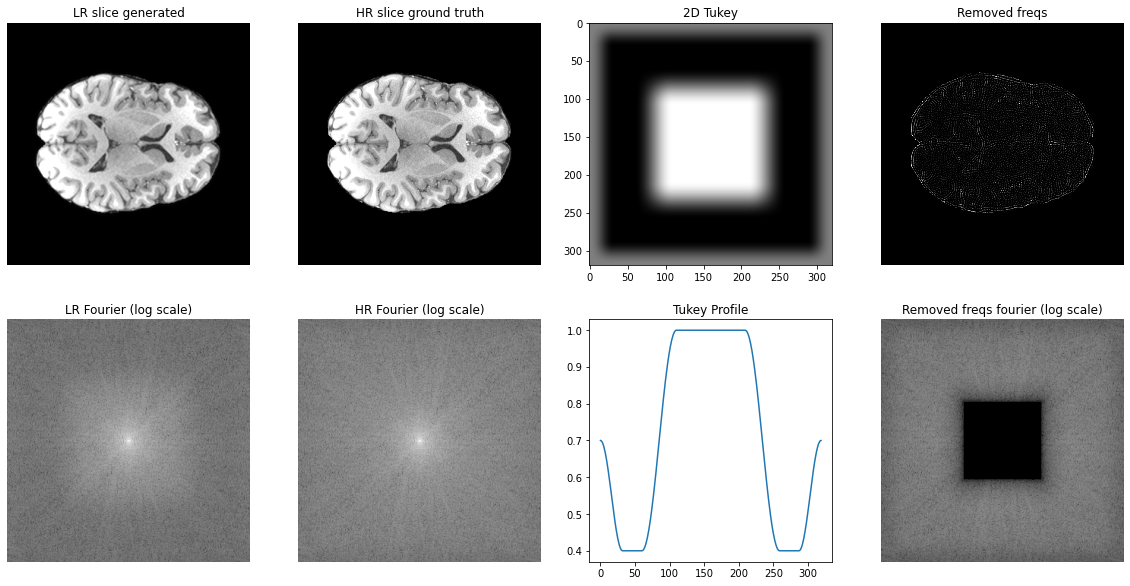

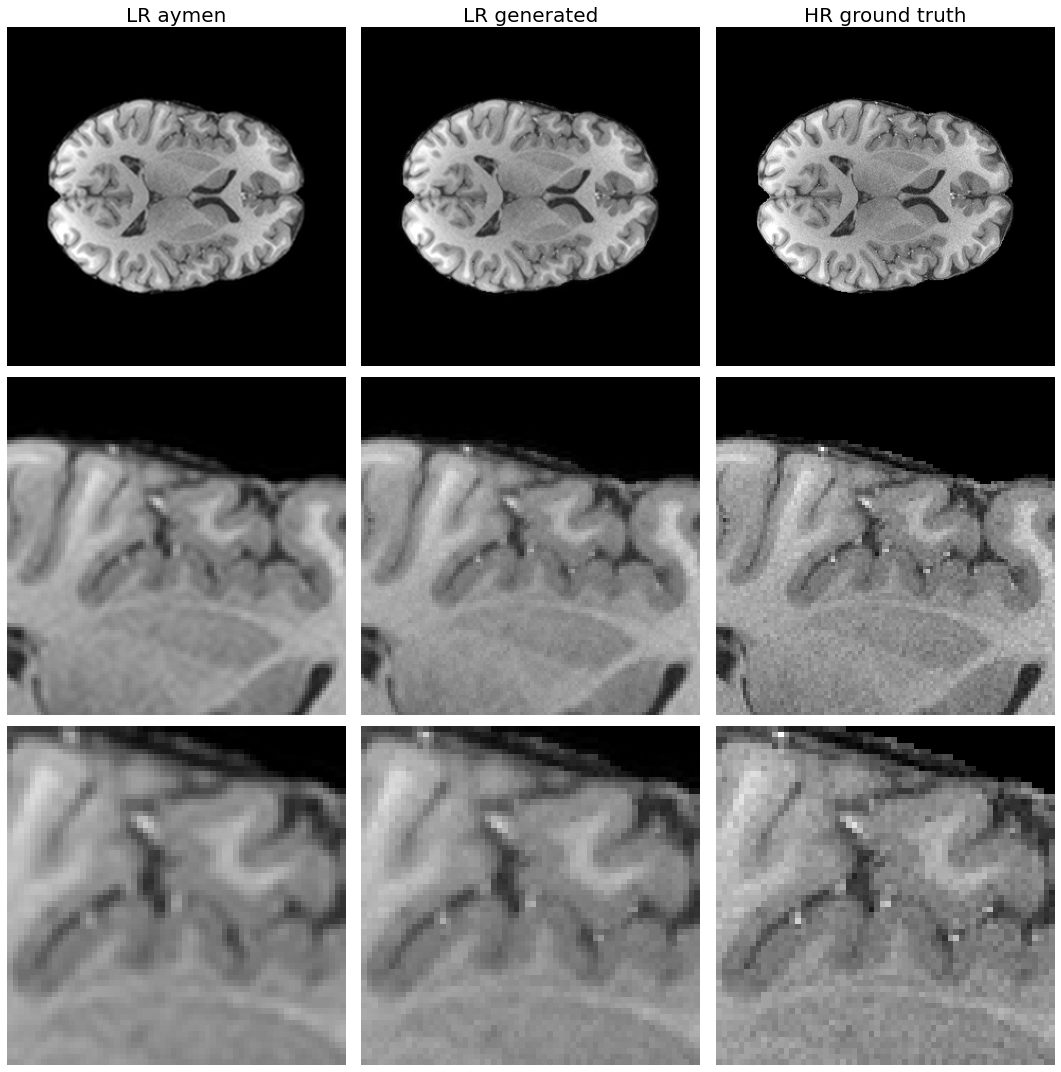

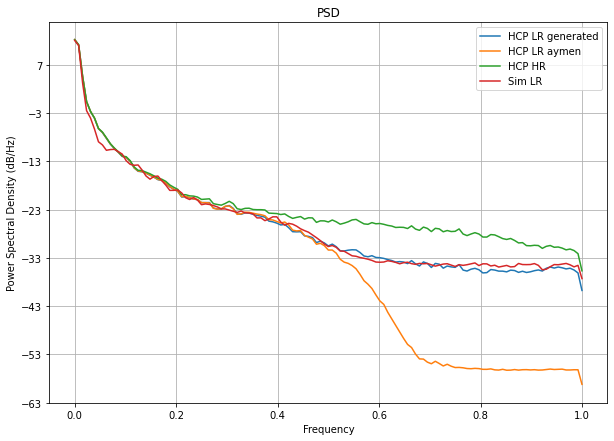

In [149]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.set_facecolor('white')

axes[0,0].set_title('LR slice generated')
axes[0,0].imshow(LR_slice_generated, cmap='gray', vmin=0, vmax=1.2)
axes[0,0].set_axis_off()
axes[1,0].set_title('LR Fourier (log scale)')
axes[1,0].imshow(np.log10(np.abs(kspace_filtered)+1e-10), cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,0].set_axis_off()

axes[0,1].set_title('HR slice ground truth')
axes[0,1].imshow(HR_slice, cmap='gray', vmin=0, vmax=1.2)
axes[0,1].set_axis_off()
axes[1,1].set_title('HR Fourier (log scale)')
axes[1,1].imshow(np.log10(np.abs(kspace)+1e-10), cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,1].set_axis_off()

axes[0,2].set_title('2D Tukey')
axes[0,2].imshow(Bt25, cmap='gray')
axes[1,2].set_title('Tukey Profile')
axes[1,2].plot(Bt25[160,:])
axes[1,2].set_box_aspect(1)

axes[0,3].set_title('Removed freqs')
axes[0,3].imshow(HR_slice-LR_slice, cmap='gray', vmin=0, vmax=.2)
axes[0,3].set_axis_off()
axes[1,3].set_title('Removed freqs fourier (log scale)')
axes[1,3].imshow(np.log10(np.abs(kspace-kspace_filtered)+1e-10), cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,3].set_axis_off()

LR_org = img_real.subject()['LR'].data[0,:,:,slice].numpy()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.set_facecolor('white')
for axis in axes:
    for xs in axis:
        xs.set_axis_off()

zoomed1 = [50,150,120,220]
zoomed2 = [70,130,140,200]

axes[0,0].set_title('LR aymen', size=20)
axes[0,0].imshow(LR_org, cmap='gray', vmin=0, vmax=1.5)
axes[1,0].imshow(LR_org[zoomed1[0]:zoomed1[1],zoomed1[2]:zoomed1[3]], cmap='gray', vmin=0, vmax=1.5)
axes[2,0].imshow(LR_org[zoomed2[0]:zoomed2[1],zoomed2[2]:zoomed2[3]], cmap='gray', vmin=0, vmax=1.5)

axes[0,1].set_title('LR generated', size=20)
axes[0,1].imshow(LR_slice_generated, cmap='gray', vmin=0, vmax=1.5)
axes[1,1].imshow(LR_slice_generated[zoomed1[0]:zoomed1[1],zoomed1[2]:zoomed1[3]], cmap='gray', vmin=0, vmax=1.5)
axes[2,1].imshow(LR_slice_generated[zoomed2[0]:zoomed2[1],zoomed2[2]:zoomed2[3]], cmap='gray', vmin=0, vmax=1.5)

axes[0,2].set_title('HR ground truth', size=20)
axes[0,2].imshow(HR_slice, cmap='gray', vmin=0, vmax=1.5)
axes[1,2].imshow(HR_slice[zoomed1[0]:zoomed1[1],zoomed1[2]:zoomed1[3]], cmap='gray', vmin=0, vmax=1.5)
axes[2,2].imshow(HR_slice[zoomed2[0]:zoomed2[1],zoomed2[2]:zoomed2[3]], cmap='gray', vmin=0, vmax=1.5)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=[10,7])
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.set_title('PSD')
ax.psd(LR_slice_generated.flatten(), label='HCP LR generated')
ax.psd(LR_org.flatten(), label='HCP LR aymen')
ax.psd(HR_slice.flatten(), label='HCP HR')
ax.psd(img_sim.subject()['LR'].data[0,:,:,slice].flatten(), label='Sim LR')
ax.legend()

In [ ]:
LR_vol = img_real.subject()['LR'].data.numpy()
HR_vol = img_real.subject()['HR'].data.numpy()

window = signal.tukey(LR_vol.shape[1], alpha=0.5)
window2d = np.repeat(window[:,np.newaxis], LR_vol.shape[2], axis=1)
mask = (1-(np.rot90(window2d)*window2d))*30
mask3d = np.repeat(mask[:, :, np.newaxis], LR_vol.shape[3], axis=2)
mask3d = mask3d[np.newaxis, :]
fourier_lr = np.fft.fftshift(np.fft.fftn(LR_vol))
fourier_hr = np.fft.fftshift(np.fft.fftn(HR_vol))
added = fourier_lr+mask3d*fourier_lr
reverse = np.fft.ifftn(np.fft.ifftshift(added))

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
fig.set_facecolor('white')

axes[0,0].set_title('LR slice')
axes[0,0].imshow(LR_vol[0,:,:,100], cmap='gray', vmin=0, vmax=1.2)
axes[0,0].set_axis_off()
axes[1,0].set_title('LR Fourier (log scale)')
axes[1,0].imshow(np.log10(np.abs(fourier_lr))[0,:,:,100], cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,0].set_axis_off()

axes[0,1].set_title('HR slice')
axes[0,1].imshow(HR_vol[0,:,:,100], cmap='gray', vmin=0, vmax=1.2)
axes[0,1].set_axis_off()
axes[1,1].set_title('HR Fourier (log scale)')
axes[1,1].imshow(np.log10(np.abs(fourier_hr))[0,:,:,100], cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,1].set_axis_off()

axes[0,2].set_title('2D Tukey')
axes[0,2].imshow(mask3d[0,:,:,100], cmap='gray')
axes[1,2].set_title('Tukey Profile')
axes[1,2].plot(mask3d[0,160,:,:])
axes[1,2].set_box_aspect(1)

axes[0,3].set_title('Added freqs LR (increased contrast)')
axes[0,3].imshow(np.abs(np.fft.ifftn(np.fft.ifftshift(mask3d*fourier_lr)))[0,:,:,100], cmap='gray', vmin=0, vmax=1)
axes[0,3].set_axis_off()
axes[1,3].set_title('Added freqs fourier LR (log scale)')
axes[1,3].imshow(np.log10(np.abs(mask3d*fourier_lr+1e-10))[0,:,:,100], cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,3].set_axis_off()

axes[0,4].set_title('LR slice + added freqs')
axes[0,4].imshow(np.abs(reverse)[0,:,:,100], cmap='gray', vmin=0, vmax=1.2)
axes[0,4].set_axis_off()
axes[1,4].set_title('LR Fourier + added freqs (log scale)')
axes[1,4].imshow(np.log10(np.abs(added))[0,:,:,100], cmap='gray', vmin=-2.5, vmax=4.5)
axes[1,4].set_axis_off()


fig = plt.figure(figsize=[10,7])
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.set_title('PSD')
ax.psd(LR_vol[0,:,:,100].flatten(), label='LR')
ax.psd(np.abs(reverse)[0,:,:,100].flatten(), label='LR Tukey')
ax.psd(HR_vol[0,:,:,100].flatten(), label='HR')
ax.legend()

In [ ]:
LR_fft_slice = torch.fft.fftshift(torch.fft.fft2(LR_slice))
LR_fft_masked_slice = LR_fft_slice*square_mask(LR_slice, (170,250))
LR_highpass_slice = torch.abs(torch.fft.ifft2(LR_fft_masked_slice))
LR_sharpened_slice = LR_slice+LR_highpass_slice*5

In [ ]:
LR = img_real.subject()['LR'].data.squeeze().numpy()
LR_highpass_gauss = LR - filters.gaussian(LR, sigma=(1,1,0), preserve_range=True)
LR_sharpened_vol_gauss = torch.tensor(LR + 0.5 * LR_highpass_gauss).unsqueeze(0)

In [ ]:
LR = img_real.subject()['LR'].data.squeeze()

size = (170,250)
mask = cuboid_mask(LR, size)
mask_gauss = filters.gaussian(mask, sigma=5)
plt.imshow(mask_gauss[:,:,100], cmap='gray')

LR_fft_vol = torch.fft.fftshift(torch.fft.fftn(LR))
LR_fft_masked_vol = LR_fft_vol * mask_gauss
LR_highpass_vol = torch.abs(torch.fft.ifftn(torch.fft.ifftshift(LR_fft_masked_vol)))
LR_sharpened_vol_img = (LR + LR_highpass_vol*5).unsqueeze(0)

In [ ]:
LR = img_real.subject()['LR'].data.squeeze()

size = (220,250)
mask = cuboid_mask(LR, size)
mask_gauss = filters.gaussian(mask, sigma=5)

LR_fft_vol = torch.fft.fftshift(torch.fft.fftn(LR))
LR_fft_masked_vol = LR_fft_vol * mask_gauss
LR_fft_sharpened = LR_fft_vol + LR_fft_masked_vol*20
LR_sharpened_vol_fft = (torch.abs(torch.fft.ifftn(torch.fft.ifftshift(LR_fft_sharpened)))).unsqueeze(0)

In [ ]:
fig = plt.figure(figsize=[10,7])
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.set_title('PSD different datasources')
ax.psd(img_sim.subject()['LR'].data[0,:,:,slice].flatten(), label='Sim 1mm')
ax.psd(img_sim.subject()['HR'].data[0,:,:,slice].flatten(), label='Sim 0.7mm')
ax.psd(img_real.subject()['LR'].data[0,:,:,slice].flatten(), label='HCP 1mm')
ax.psd(img_real.subject()['HR'].data[0,:,:,slice].flatten(), label='HCP 0.7mm')
# ax.psd(LR_sharpened_vol_gauss[0,:,:,slice].flatten(), label='HCP LR gauss')
# ax.psd(LR_sharpened_vol_img[0,:,:,slice].flatten(), label='HCP LR added freqs')
# ax.psd(LR_sharpened_vol_fft[0,:,:,slice].flatten(), label='HCP LR fft')
ax.psd(img_oasis.subject()['LR'].data[0,:,:,80].flatten(), label='OASIS 1mm')
ax.psd(img_mrbrains18.subject()['LR'].data[0,:,:,23].flatten(), label='MRBrains18 2mm')
ax.psd(img_mrbrains18.subject()['HR'].data[0,:,:,23].flatten(), label='MRBrains18 1mm')

ax.legend()

In [ ]:
LR = img_real.subject()['LR'].data[0,:,:,slice]
HR = img_real.subject()['HR'].data[0,:,:,slice]
LR_gauss = LR_sharpened_vol_gauss[0,:,:,slice]
LR_img = LR_sharpened_vol_img[0,:,:,slice]
LR_fft = LR_sharpened_vol_fft[0,:,:,slice]
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 15))
fig.set_facecolor('white')
for axis in axes:
    for xs in axis:
        xs.set_axis_off()

zoomed1 = [50,150,120,220]
zoomed2 = [70,130,140,200]

axes[0,0].set_title('LR', size=20)
axes[0,0].imshow(LR, cmap='gray', vmin=0, vmax=1.5)
axes[1,0].imshow(LR[zoomed1[0]:zoomed1[1],zoomed1[2]:zoomed1[3]], cmap='gray', vmin=0, vmax=1.5)
axes[2,0].imshow(LR[zoomed2[0]:zoomed2[1],zoomed2[2]:zoomed2[3]], cmap='gray', vmin=0, vmax=1.5)

axes[0,1].set_title('LR aug gauss', size=20)
axes[0,1].imshow(LR_gauss, cmap='gray', vmin=0, vmax=1.5)
axes[1,1].imshow(LR_gauss[zoomed1[0]:zoomed1[1],zoomed1[2]:zoomed1[3]], cmap='gray', vmin=0, vmax=1.5)
axes[2,1].imshow(LR_gauss[zoomed2[0]:zoomed2[1],zoomed2[2]:zoomed2[3]], cmap='gray', vmin=0, vmax=1.5)

axes[0,2].set_title('LR aug fft', size=20)
axes[0,2].imshow(LR_img, cmap='gray', vmin=0, vmax=1.5)
axes[1,2].imshow(LR_img[zoomed1[0]:zoomed1[1],zoomed1[2]:zoomed1[3]], cmap='gray', vmin=0, vmax=1.5)
axes[2,2].imshow(LR_img[zoomed2[0]:zoomed2[1],zoomed2[2]:zoomed2[3]], cmap='gray', vmin=0, vmax=1.5)

# axes[0,3].set_title('LR aug fft', size=20)
# axes[0,3].imshow(LR_fft, cmap='gray', vmin=0, vmax=1.5)
# axes[1,3].imshow(LR_fft[zoomed1[0]:zoomed1[1],zoomed1[2]:zoomed1[3]], cmap='gray', vmin=0, vmax=1.5)

axes[0,3].set_title('HR', size=20)
axes[0,3].imshow(HR, cmap='gray', vmin=0, vmax=1.5)
axes[1,3].imshow(HR[zoomed1[0]:zoomed1[1],zoomed1[2]:zoomed1[3]], cmap='gray', vmin=0, vmax=1.5)
axes[2,3].imshow(HR[zoomed2[0]:zoomed2[1],zoomed2[2]:zoomed2[3]], cmap='gray', vmin=0, vmax=1.5)
plt.tight_layout()
plt.show()

In [ ]:
slice = 100

LR_slice = img_real.subject()['LR'].data[0,:,:,slice]
HR_slice = img_real.subject()['HR'].data[0,:,:,slice]

# size = (4,80)
size = (80,224)

plt.imshow(fft2_plot_masked(LR_slice, square_mask(LR_slice, size)), cmap='gray')

LR_energy = freq_energy(LR_slice, square_mask(LR_slice, size))
HR_energy = freq_energy(HR_slice, square_mask(LR_slice, size))

print('LR energy: ', LR_energy.numpy())
print('HR energy: ', HR_energy.numpy())
print('Diff energy: ', (HR_energy - LR_energy).numpy())
